In [9]:
import random
import os
import copy
os.environ["OMP_NUM_THREADS"] = "1"
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import cv2
import warnings
import timeit
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torch import optim
from scipy.special import expit
from skimage import io, transform, measure
from sklearn import metrics
import optuna
from config import *
from util import *
from models import *
sns.set()
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
rc = {"figure.figsize" : (9, 7),
      "axes.spines.left" : False,
      "axes.spines.right" : False, 
      "axes.spines.bottom" : False,
      "axes.spines.top" : False,
      "xtick.bottom" : True,
      "xtick.labelbottom" : False,
      "ytick.labelleft" : False,
      "ytick.left" : True,
      "axes.grid" : False}
plt.rcParams.update(rc)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
metadata = pd.read_csv(metadata_file)

img_dir = "../data/images"

test_set = pd.read_csv("../data/test_set3.csv")

model = CharacteristicsClassifier()
model.load_state_dict(torch.load("models/combined_model.pth"))
model.to(device)
model.eval()
print('')

In [13]:
image_batch = []
for image_id in test_set.image_id.values:
    if "ISIC" in image_id:
        extension = '.jpg'
        image = io.imread(os.path.join(img_dir, image_id + extension))
        image = model.test_transform(image=image)['image']
    else:
        extension = '.png'
        image = io.imread(os.path.join(img_dir, image_id + extension), as_gray=False)[:,:,:3]
        image = model.test_transform(image=image)['image']
    image_batch.append(image)
    
image_batch = torch.stack(image_batch).to(device)


In [16]:
def forward(x):
    output = model.base_model(x)
    diagnosis_output = model.diagnosis_head(output)
    characteristics_output = model.characteristics_head(output)
    
    attributions = torch.cat([model.attribute(characteristics_output, class_idx) for class_idx in range(model.num_classes)], dim=1)
    attributions = F.interpolate(attributions, size=(image_size, image_size), mode='bilinear')
    return diagnosis_output, characteristics_output, attributions

In [17]:
diagnosis_output, characteristics_output, attributions = forward(image_batch)
predictions = torch.where(diagnosis_output >= model.dx_threshold, 1, 0).cpu().numpy().flatten()
char_predictions = torch.where(characteristics_output >= model.char_threshold, 1, 0).cpu().numpy()

In [19]:
explanations = []
for i in range(len(test_set)):
    if test_set.iloc[i].prediction == 1:
        idx = char_predictions[i][0:len(mel_class_labels)]
        
        explanation = mel_class_labels[characteristics_output[i][0:len(mel_class_labels)].argmax().item()]
        explanations.append(explanation)
    else:
        idx = char_predictions[i][len(mel_class_labels):]
        
        explanation = nev_class_labels[characteristics_output[i][len(mel_class_labels):].argmax().item()]
        explanations.append(explanation)
test_set['explanation'] = explanations

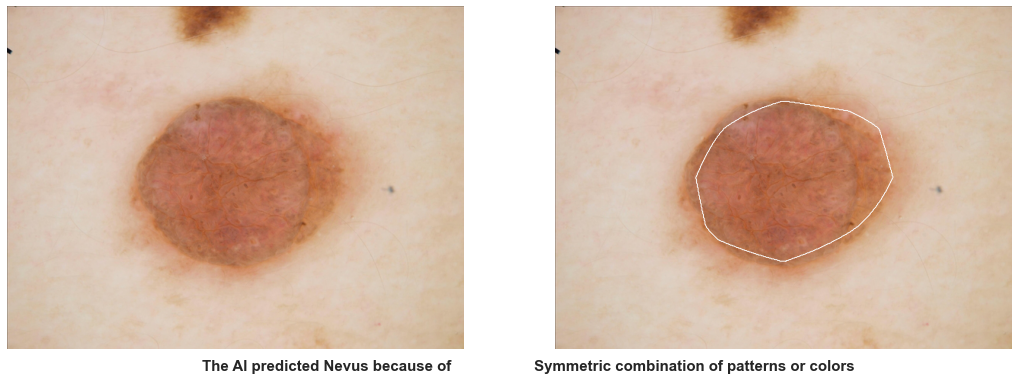

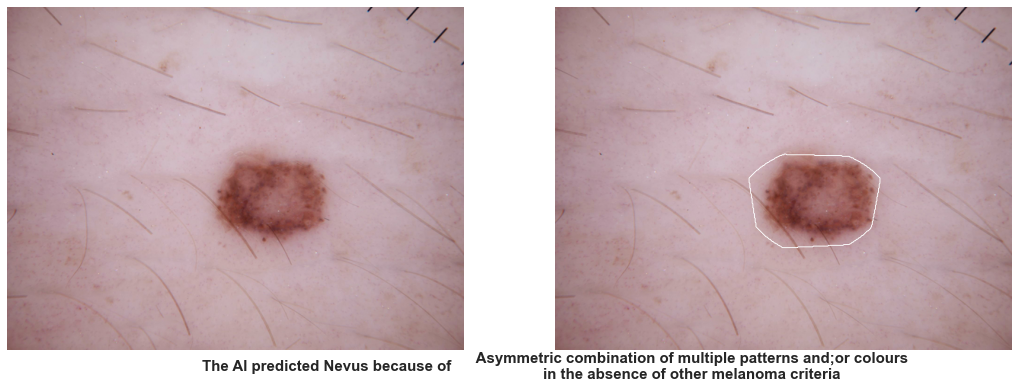

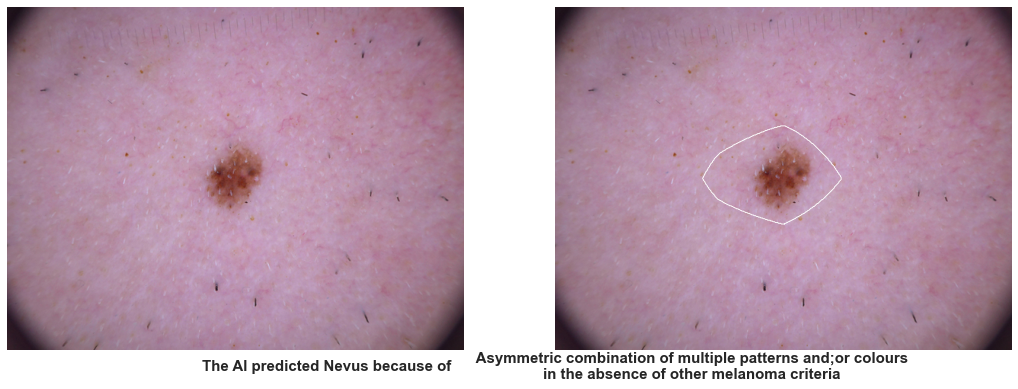

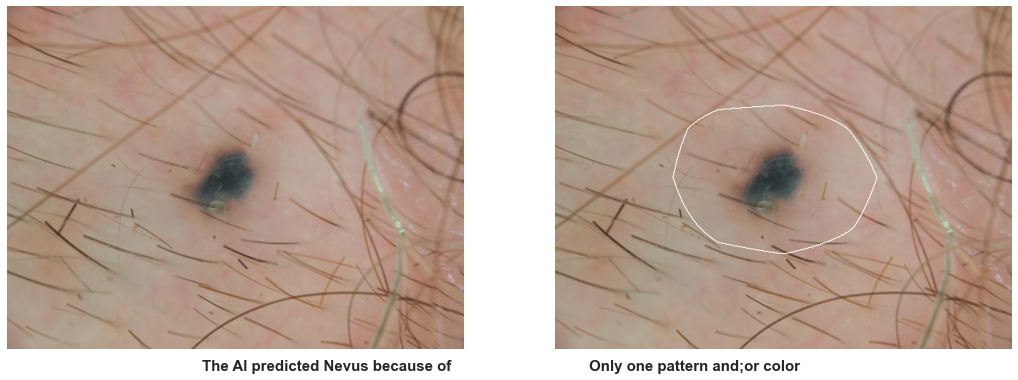

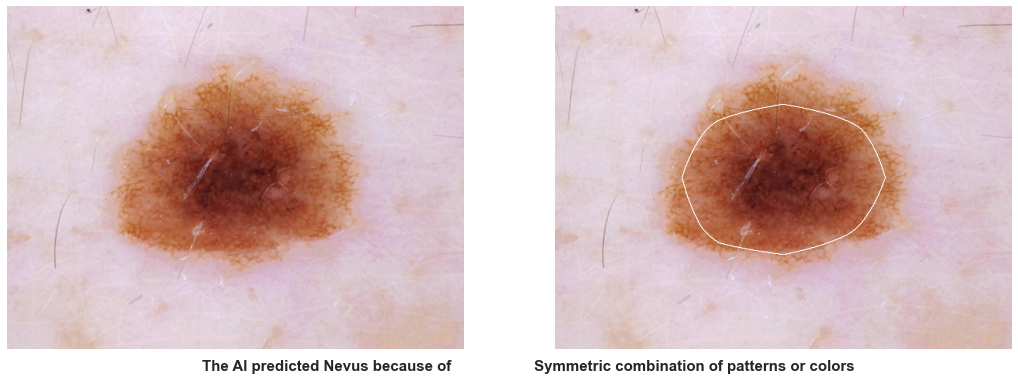

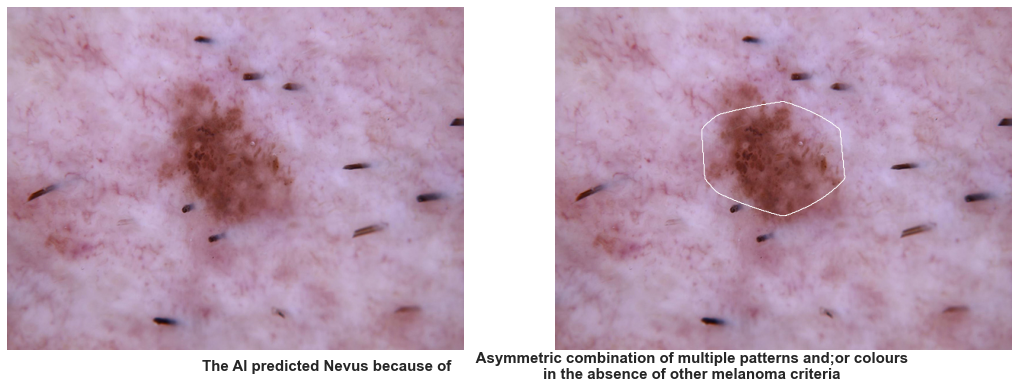

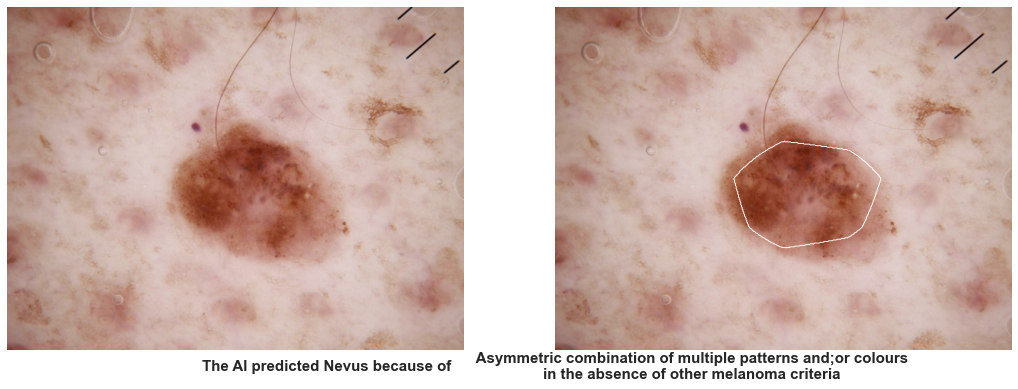

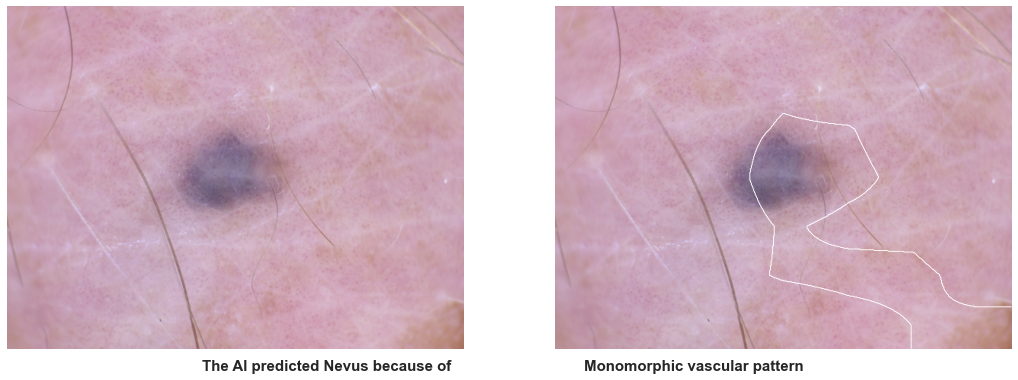

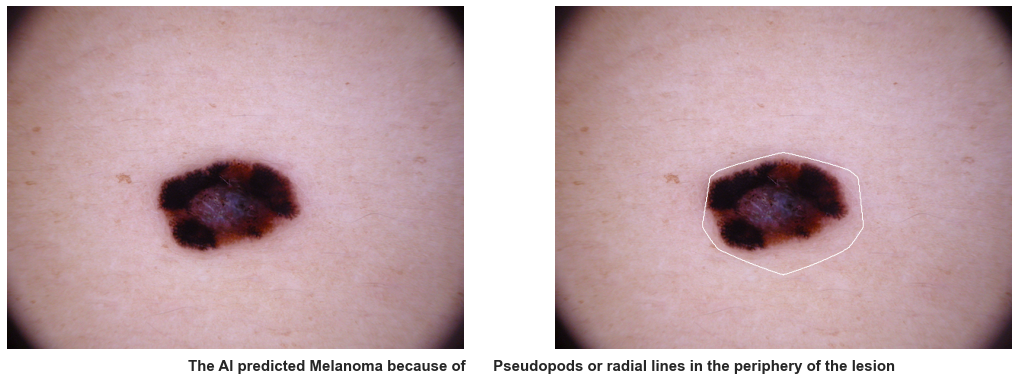

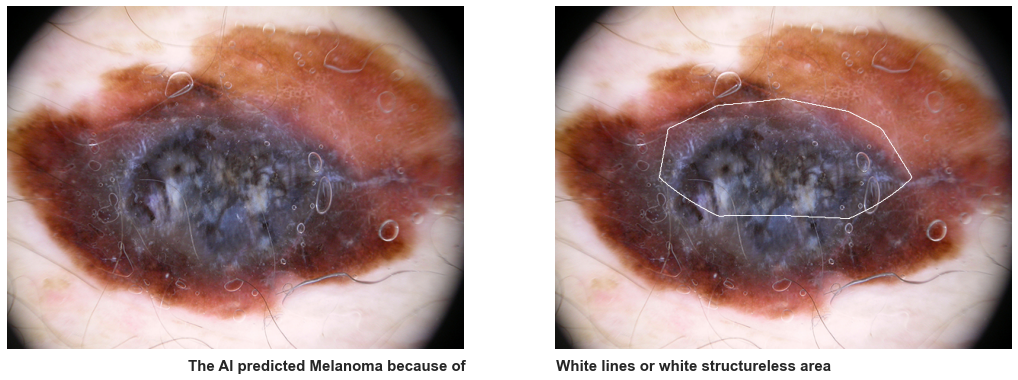

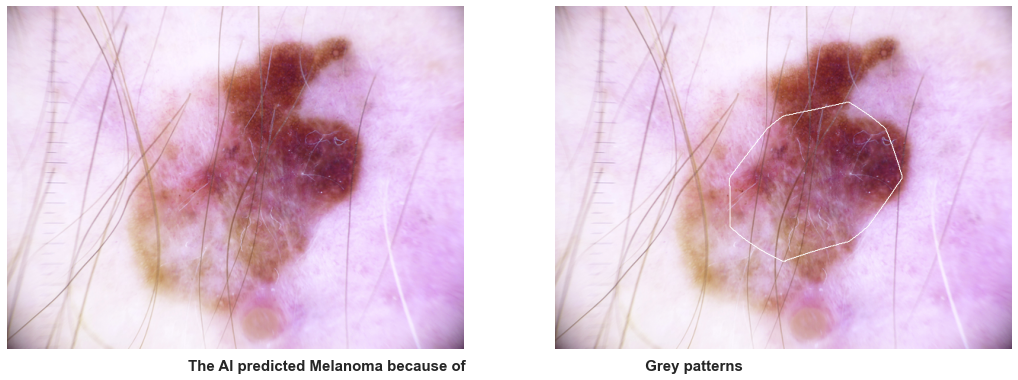

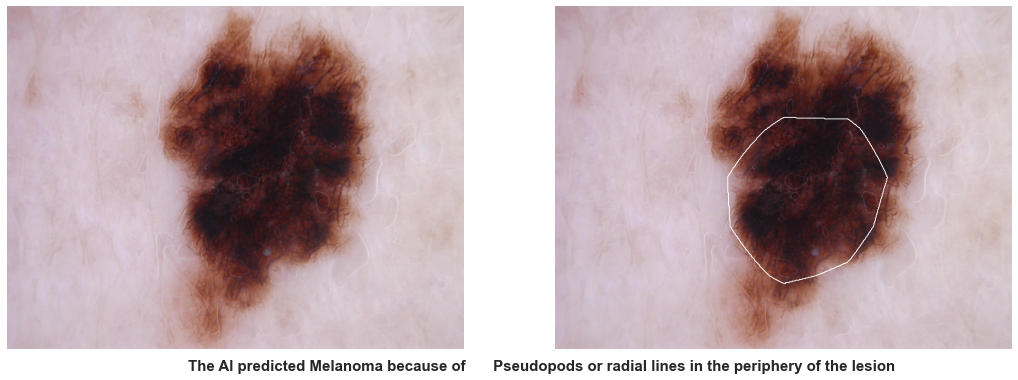

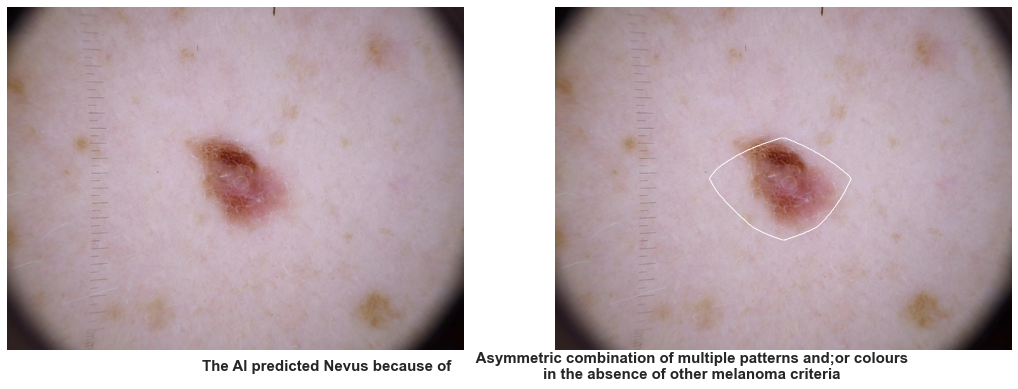

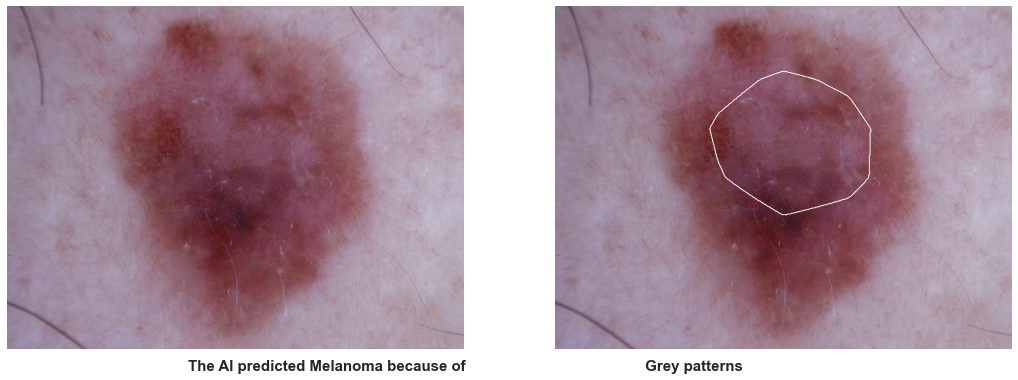

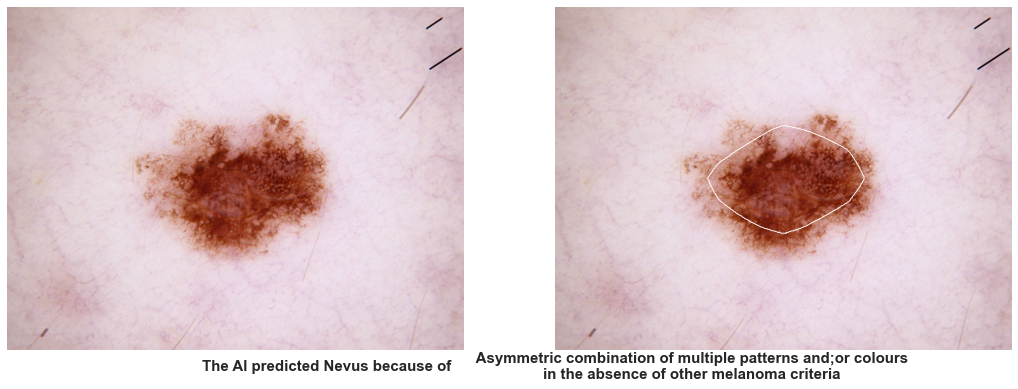

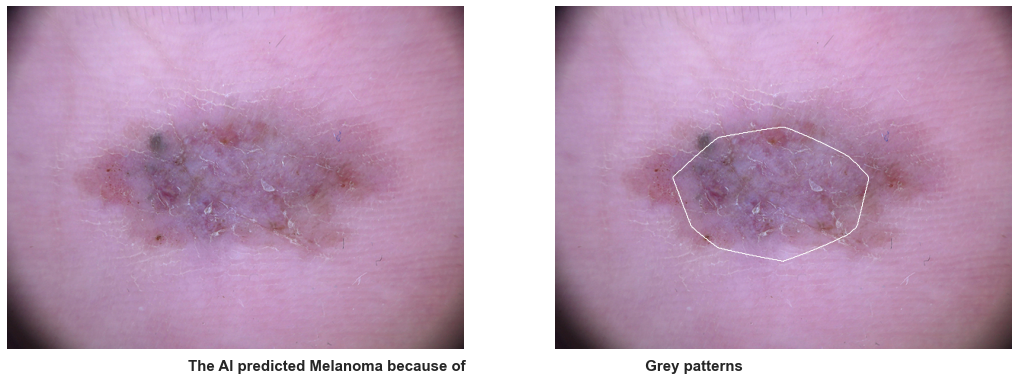

In [22]:
mappings = {
    0: 'Nevus',
    1: 'Melanoma',
    'TRBL': 'Thick reticular or branched lines',
    'BDG': 'Black dots and globules',
    'GP': 'Grey patterns',
    'WLSA': 'White lines or white structureless area',
    'PRL': 'Pseudopods or radial lines in the periphery of the lesion',
    'PV': 'Polymorphous vessels',
    'SPC': 'Symmetric combination of patterns or colors',
    'APC': 'Asymmetric combination of multiple patterns and;or colours \nin the absence of other melanoma criteria',
    'OPC': 'Only one pattern and;or color',
    'MVP': 'Monomorphic vascular pattern'
}

for idx, row in test_set.iterrows():

    try:
        img = io.imread(os.path.join(img_dir, row.image_id+'.png'))
    except:
        img = io.imread(os.path.join(img_dir, row.image_id+'.jpg'))
    img = transform.resize(img, (450, 600))

    attr = attributions[idx][char_class_labels.index(row.explanation)].cpu().detach().numpy()
    attr = transform.resize(attr, (450, 600))
        
    attr_non_zero = attr[attr>0.]
    if len(attr_non_zero) == 0:
        perc = 0
    else:
        perc = (np.percentile(attr_non_zero, 85))
    attr = (attr >= perc)
    
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
    contours = measure.find_contours(attr)
    for contour in contours:
        ax[1].plot(contour[:, 1], contour[:, 0], linewidth=0.9, color='white')
    
    ax[0].imshow(img)
    ax[1].imshow(img)
    text = f"The AI predicted {mappings[row.prediction]} because of"
    ax[0].text(0.7, -0.05, text, fontsize=15, ha='center', va='center', weight='bold', transform=ax[0].transAxes)
    text = f" {mappings[row.explanation]}"
    ax[1].text(0.3, -0.05, text, fontsize=15, ha='center', va='center', weight='bold', transform=ax[1].transAxes)
    ax[1].axis('off')
    ax[0].axis('off')

    print()